# Latent Diffusion

In the previous notebooks, we've seen how diffusion models can generate images by learning to denoise pixel space directly. However, working directly in pixel space has limitations: high-resolution images require enormous computational resources, and the network must learn to model both high-level structure (like "this is a digit") and low-level details (like individual pixel values) simultaneously.

**Latent diffusion** solves this by working in a compressed **latent space** instead of pixel space. The key idea is:

1. **Encode**: Use a Variational Autoencoder (VAE) to compress images into a smaller latent representation (e.g., 32×32 pixels → 4×4 latents)
2. **Diffuse**: Train the diffusion model to work in this compressed latent space
3. **Decode**: Use the VAE decoder to convert the generated latents back to pixel space

This approach offers several advantages:
- **Computational efficiency**: The diffusion model processes much smaller tensors (4×4 instead of 32×32), making training and inference faster
- **Better representation**: The latent space captures semantic information more compactly, allowing the model to focus on high-level structure
- **Scalability**: This is the approach used by Stable Diffusion and other state-of-the-art models to generate high-resolution images efficiently

In this notebook, we'll:
- Build and train a VAE to learn a compressed representation of MNIST digits
- Train a diffusion model (using Flow Matching) in the latent space
- Generate new images by sampling in latent space and decoding to pixels

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.nn.functional as F

### Step 1: Building the Variational Autoencoder (VAE)

A Variational Autoencoder consists of two main components:

- **Encoder**: Compresses input images into a latent representation. Instead of producing a single latent code, it outputs a **mean** ($\mu$) and **log-variance** ($\log \sigma^2$) for each latent dimension, allowing us to sample from a distribution rather than a fixed point.

- **Decoder**: Reconstructs images from latent codes. It learns to map the compressed representation back to pixel space.

The key feature of VAEs is the **reparameterization trick**: instead of sampling directly from the encoder's output distribution (which would break backpropagation), we sample from a standard Gaussian and transform it using the learned mean and variance:

$$z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, 1)$$

This makes the sampling process differentiable, allowing end-to-end training.

Our VAE architecture:
- **Encoder**: Three convolutional layers that progressively downsample 32×32 images to 4×4 feature maps
- **Latent space**: 4 channels at 4×4 resolution (64× compression from 32×32×1)
- **Decoder**: Three transposed convolutional layers that upsample back to 32×32


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=4):
        super().__init__()
        
        # Encoder: 32x32 -> 4x4
        self.encoder = nn.Sequential(
            # 32 -> 16
            nn.Conv2d(input_dim, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            # 16 -> 8
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            # 8 -> 4
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        
        # To Mean and Variance
        # We need to predict a Mean map AND a Log-Variance map.
        self.to_moments = nn.Conv2d(64, 2 * latent_dim, kernel_size=3, padding=1)

        # Decoder (Mirror image)
        self.decoder = nn.Sequential(
            # 4 -> 8
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            # 8 -> 16
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            # 16 -> 32
            nn.ConvTranspose2d(32, input_dim, kernel_size=4, stride=2, padding=1),
            nn.Tanh() # Map to [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        # Reparametrization trick
        epsilon = torch.randn_like(mu)
        z = mu + epsilon * torch.exp(0.5 * logvar) # z = mu + sigma * epsilon
        return z
    
    def forward(self, x):
        # Encode
        enc = self.encoder(x)
        moments = self.to_moments(enc)
        mu, logvar = moments.chunk(2, dim=1)
        
        # Sample
        z = self.reparameterize(mu, logvar)
        
        # Decode
        recon = self.decoder(z)
        return recon, mu, logvar

### The VAE Loss Function

Training a VAE requires balancing two objectives:

1. **Reconstruction Loss**: The decoded image should match the original input. We use Mean Squared Error (MSE) to measure how well the VAE reconstructs the input.

2. **KL Divergence Loss**: The learned latent distribution should be close to a standard Gaussian $\mathcal{N}(0, 1)$. This regularization encourages the latent space to be smooth and well-structured, making it easier for the diffusion model to learn meaningful patterns later.

The total loss is:
$$\mathcal{L}_{\text{VAE}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}$$

Where $\mathcal{L}_{\text{KL}} = -0.5 \sum (1 + \log \sigma^2 - \mu^2 - \sigma^2)$ encourages the latent distribution to match a standard Gaussian. In our implementation, we use $\beta = 1$ (though some variants like $\beta$-VAE use different values to control the trade-off).


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # 1. Reconstruction Loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # 2. KL Divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
    
    return recon_loss + kld_loss

### Step 2: Training the VAE

Now we'll train the VAE to learn a good compressed representation of our MNIST digits. The training process is straightforward: for each image, we encode it to a latent, sample from the latent distribution, decode back to pixels, and minimize the combined reconstruction and KL divergence loss.

Once trained, the VAE encoder will compress each 32×32 image into a 4×4×4 latent representation, and the decoder will be able to reconstruct reasonable approximations of the original images from these latents.


In [40]:
def load_mnist(image_size=32, batch_size=128, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])
    dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    return dataset, dataloader

In [41]:
# 1. Configuration
IMAGE_SIZE = 32
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset, dataloader = load_mnist(image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, device=device)

In [42]:
VAE_EPOCHS = 20
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

In [ ]:
# --- 4. VAE Training Loop ---
print("Starting VAE Training...")
vae_model.train()

for epoch in range(VAE_EPOCHS):
    epoch_losses = []
    
    for step, (images, _) in enumerate(dataloader):
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = vae_model(images)
        
        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backpropagation
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()
        
        epoch_losses.append(loss.item())
        
        if step % 100 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")
    print(f"Epoch {epoch} Avg Loss: {sum(epoch_losses)/len(epoch_losses):.4f}")

Let's visualize some reconstructions to see how well our VAE learned to compress and decompress the images. The top row shows original images, and the bottom row shows their reconstructions from the compressed latent representation. Some blurriness is expected—this is the trade-off for compression, but the VAE should preserve the essential structure of each digit.


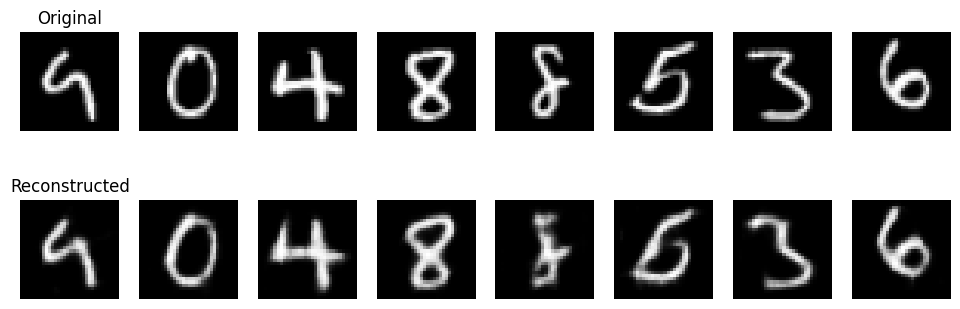

In [44]:
vae_model.eval()

# 1. Get a batch
images, _ = next(iter(dataloader))
images = images.to(device)

# 2. Reconstruct
with torch.no_grad():
    recon_images, _, _ = vae_model(images)

# 3. Plot
fig, axes = plt.subplots(2, 8, figsize=(12, 4))

# Top row: Originals
for i in range(8):
    # Un-normalize
    img = (images[i, 0].cpu() + 1) / 2
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].axis('off')

    if i == 0: axes[0, i].set_title("Original")

# Bottom row: Reconstructions
for i in range(8):
    # Un-normalize
    img = (recon_images[i, 0].cpu() + 1) / 2
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title("Reconstructed")
    
plt.show()

Once we're done with training our vae model, it's time for latent diffusion. First, we create and encoded version of our dataset, such that we can skip encoding each time every image.

In [ ]:
@torch.no_grad()
def encode_dataset(model, dataloader):
    model.eval()
    latents = []
    all_labels = []
    
    print("Encoding dataset...")
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            
            # Pass images through the encoder
            enc = model.encoder(images) 
            # Get the mean (mu)
            moments = model.to_moments(enc)
            mu, _ = moments.chunk(2, dim=1)
            
            latents.append(mu.cpu())
            all_labels.append(labels)
            
    return torch.cat(latents, dim=0), torch.cat(all_labels, dim=0)

latent_data, latent_labels = encode_dataset(vae_model, dataloader)
print(f'latent_data shape: {latent_data.shape}')  # Should be (N, latent_dim)

### Step 3: The Latent Diffusion Model

Now that we have a compressed latent representation, we can train a diffusion model to work in this space. Since we're working with 4×4 latents instead of 32×32 images, we can use a simpler architecture than the full U-Net we saw before.

Our **LatentDiffuser** is essentially a ResNet-style network:
- **Input projection**: Maps the 4-channel latent to a higher-dimensional feature space (64 channels)
- **Processing blocks**: A sequence of residual blocks that process the latent while maintaining the 4×4 spatial size
- **Output projection**: Maps back to 4 channels (matching the latent dimension)

Each block incorporates:
- **Time embeddings**: So the network knows which timestep it's denoising
- **Label embeddings**: For conditional generation (we'll condition on digit labels, 0-9)

Unlike the U-Net, we don't need downsampling/upsampling because we're already working at the compressed resolution. This makes the architecture simpler and faster to train.


We'll reuse the `SinusoidalEmbedding` class from previous notebooks to encode timesteps. This allows the network to understand how much noise is present at different stages of the diffusion process.


In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        
    def forward(self, t):
            device = t.device
            emb = torch.zeros(t.shape[0], self.embedding_dim, device=device)
            
            for i in range(self.embedding_dim // 2):
                # We ensure the constant is on the correct device too
                const = torch.tensor(10000.0, device=device) 
                omega_i = torch.exp(-(2*i/self.embedding_dim) * torch.log(const))
                
                emb[:, 2*i] = torch.sin(omega_i * t)
                emb[:, 2*i+1] = torch.cos(omega_i * t)
            
            return emb

As we already reached a compact representation via the variational autoencoder, we should now change the UNet structure such that we skip the contraption part. We define a new latent diffuser model, which is basically a ResNet based on our Block modules working in the latent space.

In [ ]:
class LatentDiffuser(nn.Module):
    def __init__(self):
        super().__init__()
        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(32),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        
        # 1. Input Projection (4 channels -> 64 channels)
        self.conv_in = nn.Conv2d(4, 64, kernel_size=3, padding=1)
        
        # 2. Body (Just a sequence of Blocks, keeping size 4x4)
        self.block1 = Block(64, 128, 32)
        self.block2 = Block(128, 256, 32)
        self.block3 = Block(256, 128, 32) # Shrink channels back down
        
        # 3. Output Projection (128 channels -> 4 channels)
        self.final = nn.Conv2d(128, 4, kernel_size=3, padding=1)
        
        # Label Embedding (for Conditional Generation)
        self.label_emb = nn.Embedding(10, 32)

    def forward(self, x, t, labels):
        # Embed Time & Labels
        t = self.time_mlp(t)
        label_emb = self.label_emb(labels)
        
        t = t + label_emb
        
        # Run the blocks
        x = self.conv_in(x)
        
        x = self.block1(x, t)
        x = self.block2(x, t)
        x = self.block3(x, t)
        
        return self.final(x)

We'll create a simple dataset wrapper to work with our pre-encoded latents. This allows us to use PyTorch's DataLoader for efficient batching during training.


In [ ]:
from torch.utils.data import Dataset, DataLoader

class TensorDataset(Dataset):
    def __init__(self, latent_data, labels):
        self.latent_data = latent_data
        self.labels = labels

    def __len__(self):
        return self.latent_data.shape[0]
    
    def __getitem__(self, idx):
        return self.latent_data[idx], self.labels[idx]

In [ ]:
latent_dataset = TensorDataset(latent_data, latent_labels)
dataloader = DataLoader(latent_dataset, batch_size=64, shuffle=True)

In [ ]:
diffuser = LatentDiffuser().to(device)
optimizer = optim.Adam(diffuser.parameters(), lr=1e-3)

### Flow Matching in Latent Space
We train our network based on a standarf Flow Matching approach, with the difference that now the network will learn to reconstruct the latent representations of images, instead of reconstructing the raw pixels.


In [ ]:
def compute_flow_match_loss_conditional(model, x_1, labels):
    # x_1: Real data batch (Batch, C, H, W)
    b = x_1.shape[0]
    
    # 1. Sample x_0 (Pure Gaussian Noise)
    x_0 = torch.randn_like(x_1)
    
    # 2. Sample random time t (uniform 0 to 1)
    # Make sure to reshape it to (B, 1, 1, 1) for broadcasting!
    t = torch.rand((b,), device=x_1.device)
    t_broad = t.view(-1, 1, 1, 1)
    
    # 3. Compute x_t (Linear Interpolation)
    x_t = (1-t_broad) * x_0 + t_broad * x_1
    
    # 4. Compute Target Velocity (The formula you derived)
    target_v = x_1 - x_0
    
    # 5. Predict with model
    # Note: We need to pass 't' (vector) not 't_broad' to the model usually, 
    # depending on your embedding layer. Let's assume 't' is fine.
    pred_v = model(x_t, t, labels)
    
    # 6. MSE Loss
    return torch.nn.functional.mse_loss(pred_v, target_v)

In [ ]:
LATENT_EPOCHS = 20

print("Starting Latent Flow Matching Training...")
diffuser.train()

for epoch in range(LATENT_EPOCHS):
    epoch_losses = []
    for step, (latents, labels) in enumerate(dataloader):
        latents = latents.to(device)
        labels = labels.to(device)
        
        # Calculate Flow Matching Loss
        loss = compute_flow_match_loss_conditional(diffuser, latents, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        if step % 100 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")
            
    print(f"Epoch {epoch} Avg Loss: {sum(epoch_losses)/len(epoch_losses):.4f}")

### Step 4: Generating Images from Latent Space

Now we can generate new images! The process has three stages:

1. **Sample in latent space**: Start with pure Gaussian noise in the latent space and use the trained diffuser to iteratively denoise it using Flow Matching. We use Euler's method to integrate the velocity field over multiple steps.

2. **Decode to pixel space**: Once we have a clean latent, pass it through the VAE decoder to get a 32×32 image.

3. **Visualize**: Display the generated images.

The beauty of this approach is that all the expensive diffusion computation happens in the small 4×4 latent space, and we only decode once at the end. This makes generation much faster than working directly in pixel space.


In [ ]:
@torch.no_grad()
def sample_latent_flow_matching(diffuser, vae, labels, steps=50, device=device):
    diffuser.eval()
    vae.eval()
    n_samples = len(labels)
    
    # 1. Start with LATENT noise (4x4 spatial size, 4 channels)
    # Note: size is 4, not 32!
    x = torch.randn(n_samples, 4, 4, 4, device=device)
    
    dt = 1.0 / steps
    
    # 2. Run Flow Matching (Latent Space)
    for i in range(steps):
        t = i * dt
        t_batch = torch.full((n_samples,), t, device=device)
        
        # Get velocity
        v = diffuser(x, t_batch, labels)
        
        # Euler step
        x = x + v * dt
        
    # 3. Decode (Latent -> Pixel)
    # x is now our generated latent. Pass it to VAE decoder.
    print("Decoding latents...")
    decoded_images = vae.decoder(x)
    
    return decoded_images

Decoding latents...


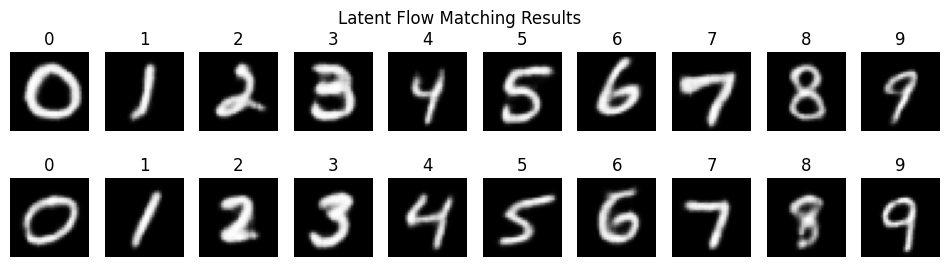

In [ ]:

# --- Run Generation ---
labels = torch.arange(10).to(device)
# Combine to get 20 samples (0-9, 0-9)
labels = torch.cat([labels, labels]) 

final_images = sample_latent_flow_matching(diffuser, vae_model, labels, steps=5)

# --- Plotting ---
final_images = (final_images + 1) / 2
final_images = final_images.clamp(0, 1).cpu()

fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(final_images[i, 0], cmap='gray')
    ax.axis('off')
    ax.set_title(f"{labels[i].item()}")
plt.suptitle("Latent Flow Matching Results")
plt.show()

## Final Thoughts

We've now implemented a complete latent diffusion pipeline! This approach combines the best of both worlds: the expressive power of diffusion models with the efficiency of working in compressed latent space.

**Key Concepts:**
- **VAE Compression**: Using a Variational Autoencoder to learn a compact latent representation of images
- **Latent Space Diffusion**: Training the diffusion model to work in the compressed space rather than pixel space
- **Flow Matching**: An alternative to DDPM that learns velocity fields for faster and more stable training
- **End-to-End Pipeline**: Encoding → Diffusion → Decoding to generate high-quality images efficiently

**Why This Matters:**
Latent diffusion is the foundation of modern image generation models like Stable Diffusion. By working in latent space, we can:
- Generate high-resolution images with manageable computational costs
- Focus the model's capacity on learning semantic structure rather than pixel-level details
- Scale to larger images and more complex datasets